In [1]:
import glob
import os.path
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os, shutil, pathlib, fnmatch
import scipy.ndimage as ndimage
from tempfile import TemporaryFile
import plotly.express as px
%matplotlib inline

#Создаем вложенные папки для сортировки файлов

def CreateFolder():
    try:
        #Делаем проверку на их наличие
        if not os.path.isdir("png") or not os.path.isdir("ox") or not os.path.isdir("plot") or not os.path.isdir("npy"):
            os.mkdir("png")
            os.mkdir("ox")
            os.mkdir("npy")
    except: pass

#Вычисляем среднее значение кровотока мышки
def mean_bloodflow(file):
    
    #индекс кровотока - это обратная величина той, что записана в файлах
    #формат данных в файлах - Float 32

    bloodflow_index = 1/np.fromfile(file, dtype=np.float32)
    
    #поскольку в результате у вас получается одномерный массив, его лучше собрать в массив продолжительность съёмкиx512x512
    bloodflow_index = bloodflow_index.reshape(int(bloodflow_index.shape[0]/512/512),512,512)
    
    #далее файл можно сгладить гауссовым фильтром
    bloodflow_index_smooth = ndimage.gaussian_filter(bloodflow_index, sigma=(1, 3, 3), order=0)
    
    #далее вы в отдельной переменной считаете среднюю картинку на образец
    mean_bloodflow_index_smooth = bloodflow_index_smooth.mean(axis=0)
    
    return mean_bloodflow_index_smooth

#Выделяем выделенную область в виде одномерного массива
def bloodflowCut(file):
    
    #Проделываем аналогичные операции, за исключением усреднения
    bloodflow_index = 1/np.fromfile(file, dtype=np.float32)
    
    bloodflow_index = bloodflow_index.reshape(int(bloodflow_index.shape[0]/512/512),512,512)
    
    bloodflow_index_smooth = ndimage.gaussian_filter(bloodflow_index, sigma=(1, 3, 3), order=0)
    
    # заданием формат среза
    xsize = 200 
    ysize = 200
    # задаем координаты
    x0 = 180
    y0 = 150
        
    return bloodflow_index_smooth[:,x0:x0+xsize,y0:y0+ysize]

def plotdef(mean_bloodflow, file, file_loc):
    
    #размер области по осям X и Y
    xsize=200
    ysize=200
    
    #начальные координаты. координаты (0,0) лужат в ВЕРХНЕМ левом углу
    x0 = 180
    y0 = 150
    
    plt.figure(figsize=(6,6)) # размер изображения в дюймах
    plt.imshow(mean_bloodflow,extent=(0,512,512,0)) #рисуем среднюю картинку

    plt.colorbar(shrink=0.8,label = 'Bloodflow index') #рисуем рядом шкалу псевдоцвета
    plt.title(file)
    plt.axis('off') #отрубаем подписи осей 

    #если промазали по органу - именяем вначале координаты x0 и y0, пока не попадем 
    plt.axhspan(ymin=y0,ymax=y0+ysize,xmin=x0/512,xmax=(x0+xsize)/512,color='#ffffff55')
        
    os.chdir(file_loc)
    
    plt.savefig(file[:-4] + '.png' ,dpi=300,bbox_inches='tight')
    plt.show()

# на всякий случай деф для удаления png и npy файлов
def delete_files(Path):
    for Foldername in os.listdir(Path):
        file_destination_png_def = str(Path + '/' + Foldername + "/" + 'png' + '/')
        file_destination_npy_def = str(Path + '/' + Foldername + "/" + 'npy' + '/')
        
        #немного спагетти-кода
        for i in os.listdir(file_destination_png_def):
            os.remove(file_destination_png_def+ i)
        for j in os.listdir(file_destination_npy_def):
            os.remove(file_destination_npy_def+ j)

def CreateAndWriteNpyData(Data, file_location, file):
    
    #направляемся в папку
    os.chdir(file_location)
    
    #создаем и записываем, сохраняем файл с расширением .npy
    np.save(file_location + '/' + file[:-4] + '.npy', Data)

C:\Users\zamot\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Указываем корневой путь
Path = str('C:\Documents\DataforPracticise')
 
for Foldername in os.listdir(Path):

    #собираем путь
    local_path = str (Path + '\\' + Foldername)
    
    #перемещаемся в локальную папку
    os.chdir(local_path)
    
    #Создаем папки для сортировки
    CreateFolder()
    
    file_destination1 = str(local_path + "\\" + 'ox')
    file_destination2 = str(local_path + "\\" + 'plot')
    
    #root - все содержащиеся атрибуты dirs - каталоги вложенных папок files - имеющиеся файлы
    for root, dirs, files in os.walk(local_path):
        # цикл перебора файлов из каталога файлов
        for fileName in files:
            try:
                #сортируем файлы для обработки по папкам
                if ("ox" in fileName):
                    # это нам пока что не нужно
                    shutil.move(local_path + "\\" + fileName, file_destination1)
                if  (fileName.endswith(".txt")):
                    # это нам пока что не нужно
                    shutil.move(local_path + "\\" + fileName, file_destination2)
            except: pass  
    
    #Перемещаемся в корневую папку, чтобы выйти из цикла
    os.chdir(Path)

#Проверяем, в каком каталоге находимся     
os.getcwd()

'C:\\Documents\\DataforPracticise'

In [3]:
#delete_files(Path)
#os.getcwd()

In [20]:
#Получаем сами папки
for Foldername in os.listdir(Path):
    
    #Проходимся по атрибутам папок
    for file in (os.listdir(Foldername)):
        
        if (".dat" in file):  
            
            # Собираем относительный путь каждого файда
            FL = Path + r'/' + str(Foldername) + r'/' + str(file)
            
            # Собираем путь, куда будем перемещать обработанные png файлы
            file_destination3 = str(Path + '\\' + Foldername + "\\" + 'png')
        
            #Собираем путь, куда будем перемещать обработанные npy данные выделенной области образца
            file_destination4 = str(Path + '\\' + Foldername + "\\" + 'npy')
            try:
                pass
                
                #Рисуем и автоматически сохраняем в папку file_destination3 относительно 
                #plotdef(mean_bloodflow(FL), file, file_destination3)
                
                #Создание и запись срезов данных в npy формат в папки (относительные пути)
                #CreateAndWriteNpyData(bloodflowCut(FL).flatten(), file_destination4, file)
                
            except: pass 
            os.chdir(Path)
#название файлов
name_file = []
#данные из файлов
df_main = []
for Foldername in os.listdir(Path):
    #print(Foldername)
    folderN1 = Path + '\\' + Foldername + '\\' + 'png' 
    #print(folderN1)

    for folder_local in os.listdir(Foldername):
        if ("npy" in folder_local):
            
            folderN = Path + '\\' + Foldername + '\\' + folder_local
            #print(folderN)
            for file in os.listdir(folderN):
                x = folderN + '\\' + file       
                read_file =  np.load(x)
                #print(read_file)
                df_main.append(read_file)
                if ("npy" in file):
                    name_file.append(file)
        os.chdir(Path)

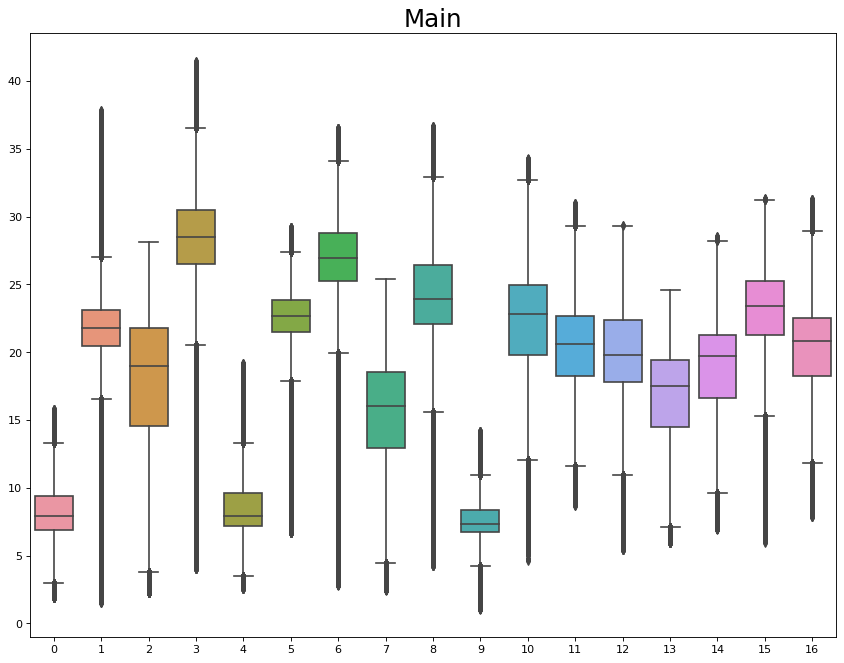

In [23]:
df = df_main

# Draw Plot
plt.figure(figsize=(13,10), dpi= 80)

sns.boxplot(data=df)
#sns.stripplot(x='class', y='hwy', data=df, color='black', size=3, jitter=1)

#for i in range(len(df['class'].unique())-1):
    #plt.vlines(i+.5, 10, 45, linestyles='solid', colors='gray', alpha=0.2)

# Decoration
plt.title('Main', fontsize=22)
plt.show()

#go.Box(y=df[df.Genre==genre].Critic_Score, name=genre)